##라이브러리 import

In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

# dataset and transfromation
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

#display images
from torchvision import utils
import matplotlib.pyplot as plt

#utils
import numpy as np
import time
import copy



In [3]:
#Hyperparameters
batch_size = 20
num_epochs = 50

#classes dict
img_class = {0:'airplane', 
             1:'bird', 
             2:'car', 
             3:'cat', 
             4:'deer', 
             5:'dog', 
             6:'horse', 
             7:'monkey', 
             8:'ship', 
             9:'truck'}

#device 설정
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##데이터셋

In [4]:
# 데이터 다운받을 경로 설정 
path2data = '/content/data'

# 폴더가 존재하지 않을 시 폴더 생성
if not os.path.exists(path2data):
    os.mkdir(path2data)

# 데이터 로드
train_data = datasets.STL10(root=path2data, split='train', download=True, 
                            transform=transforms.ToTensor())
test_data = datasets.STL10(root=path2data, split='test', download=True, 
                            transform=transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/data/stl10_binary.tar.gz to /content/data
Files already downloaded and verified


In [5]:
print(len(train_data), train_data[0][0].shape)
print(len(test_data), test_data[0][0].shape)

5000 torch.Size([3, 96, 96])
8000 torch.Size([3, 96, 96])


In [6]:
train_data.labels

array([1, 5, 1, ..., 1, 7, 5], dtype=uint8)

In [7]:
# RGB 정규화 -> 평균과 표춘편차 구하기
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_data]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_data]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


test_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in test_data]
test_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in test_data]

test_meanR = np.mean([m[0] for m in test_meanRGB])
test_meanG = np.mean([m[1] for m in test_meanRGB])
test_meanB = np.mean([m[2] for m in test_meanRGB])
test_stdR = np.mean([s[0] for s in test_stdRGB])
test_stdG = np.mean([s[1] for s in test_stdRGB])
test_stdB = np.mean([s[2] for s in test_stdRGB])

print((train_meanR, train_meanG, train_meanB), 
      (train_stdR, train_stdG, train_stdB))
print((test_meanR, test_meanG, test_meanB), 
      (test_stdR, test_stdG, test_stdB))

(0.4467106, 0.43980986, 0.40664646) (0.22414584, 0.22148906, 0.22389975)
(0.44723064, 0.4396425, 0.40495726) (0.22489566, 0.22172786, 0.22369827)


## Transform 객체 생성

In [8]:
# crop, horiziontal, nornalize 사용
train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(train_meanR, train_meanG, train_meanB), 
                             std=(train_stdR, train_stdG, train_stdB))
])

test_transformer = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(test_meanR, test_meanG, test_meanB), 
                             std=(test_stdR, test_stdG, test_stdB))
])

#transform 객체 적용
train_data.transform = train_transformer
test_data.transform = test_transformer

In [9]:
#transformer 적용 확인
print(train_data.transform)
print(test_data.transform)

# 사이즈 변경 확인
print(train_data[0][0].shape)
print(test_data[0][0].shape)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.4467106, 0.43980986, 0.40664646), std=(0.22414584, 0.22148906, 0.22389975))
)
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.44723064, 0.4396425, 0.40495726), std=(0.22489566, 0.22172786, 0.22369827))
)
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [10]:
# 사이즈 변경 확인
print(train_data[0][0].shape)
print(test_data[0][0].shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


##이미지 시각화

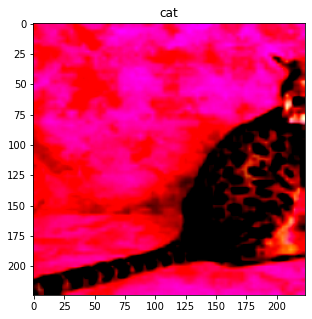

In [11]:
#이미지 시각화 함수

def show(img):
    npimg = img.numpy()
    npimg_t = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_t)

#랜덤 이미지 고르기
rnd_idx = int(np.random.randint(0,len(train_data)-1,1))
img, label = train_data[rnd_idx]
plt.figure(figsize=(5,5))
plt.title(img_class[label])
show(img)

In [12]:
#dataloader 생성
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = DataLoader(test_data, batch_size=20, shuffle=True)

In [13]:
next(iter(train_loader))[0].shape

torch.Size([20, 3, 224, 224])

##모델 생성

In [14]:
# 모델 별 cfg 작성 
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

#model
class VGGNet(nn.Module):
    def __init__(self, vgg_name, in_channels=3, num_classes=10, 
                 init_weights=True):
        super().__init__()
        self.in_channels = in_channels
        self.vgg_name = vgg_name
        self.num_classes = num_classes
        self.conv_layers = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

        if init_weights:
            self._initializer_weights()
        
    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)
        return F.log_softmax(out, dim=1)
        
    def _initializer_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode= 'fan_out', 
                                            nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias,0)


    def _make_layers(self, cfg):
        layers=[]
        in_channels = self.in_channels
        for layer in cfg:
            if layer == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels = in_channels, 
                out_channels=layer ,kernel_size=(3,3),stride =1, padding=1),
                               nn.BatchNorm2d(layer),
                               nn.ReLU()
                               ]
                in_channels = layer
        return nn.Sequential(*layers)

##모델 설정

In [20]:
model = VGGNet('VGG16').to(device)
criterion = F.nll_loss
optimizer = optim.SGD(model.parameters(), lr= 0.001, momentum=0.9)

In [21]:
summary(model, (3,224,224), batch_size=20, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [20, 64, 224, 224]           1,792
       BatchNorm2d-2         [20, 64, 224, 224]             128
              ReLU-3         [20, 64, 224, 224]               0
            Conv2d-4         [20, 64, 224, 224]          36,928
       BatchNorm2d-5         [20, 64, 224, 224]             128
              ReLU-6         [20, 64, 224, 224]               0
         MaxPool2d-7         [20, 64, 112, 112]               0
            Conv2d-8        [20, 128, 112, 112]          73,856
       BatchNorm2d-9        [20, 128, 112, 112]             256
             ReLU-10        [20, 128, 112, 112]               0
           Conv2d-11        [20, 128, 112, 112]         147,584
      BatchNorm2d-12        [20, 128, 112, 112]             256
             ReLU-13        [20, 128, 112, 112]               0
        MaxPool2d-14          [20, 128,

## Train & Test

In [22]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1)%50 == 0:
            print(f'Train Epoch: {epoch} ({100*(batch_idx+1)*batch_size/len(train_loader.dataset):.0f})%',
                  f'Loss: {loss}')


In [23]:
def test(model, device, test_loader):
    model.eval()
    test_loss=0
    correct=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum')
            pred = output.max(1)[1]
            correct += pred.eq(target).sum().item()
        
        test_loss /= len(test_loader.dataset)
        print(f"\nTest set: Average Loss:{test_loss:.4f}, Accuracy: {100 * correct / len(test_loader.dataset)}%\n")
        print('='*50)

##학습

In [ ]:
for epoch in range(1,num_epochs+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 (20)% Loss: 2.6222150325775146
Train Epoch: 1 (40)% Loss: 2.3139305114746094
Train Epoch: 1 (60)% Loss: 2.0287160873413086
Train Epoch: 1 (80)% Loss: 1.8964837789535522
Train Epoch: 1 (100)% Loss: 1.9671785831451416

Test set: Average Loss:1.8639, Accuracy: 28.7625%

Train Epoch: 2 (20)% Loss: 1.6644599437713623
Train Epoch: 2 (40)% Loss: 2.0938363075256348
Train Epoch: 2 (60)% Loss: 1.9729335308074951
Train Epoch: 2 (80)% Loss: 2.1679577827453613
Train Epoch: 2 (100)% Loss: 2.2326509952545166

Test set: Average Loss:1.7700, Accuracy: 29.1375%

Train Epoch: 3 (20)% Loss: 2.231666326522827
Train Epoch: 3 (40)% Loss: 1.9516541957855225
Train Epoch: 3 (60)% Loss: 2.1069345474243164
Train Epoch: 3 (80)% Loss: 1.9436776638031006
Train Epoch: 3 (100)% Loss: 1.890378713607788

Test set: Average Loss:1.7333, Accuracy: 32.3625%

Train Epoch: 4 (20)% Loss: 1.9176244735717773
Train Epoch: 4 (40)% Loss: 1.769989252090454
Train Epoch: 4 (60)% Loss: 1.8196672201156616
Train Epoch: 4 (